In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import nbodykit.lab
from nbodykit.lab import *
from nbodykit import style, setup_logging

from tqdm import tqdm
import numpy as np
import MAS_library as MASL
import Pk_library as PKL
import matplotlib.pyplot as plt
plt.style.use(style.notebook)

import sys, pickle, time, os

# nbodykit tool to read custom (non-standard) catalogue file type
from nbodykit.io.base import FileType
# nbodykit tool to creae custom subclass od CatalogSource
from nbodykit.source.catalog.file import FileCatalogFactory
# nbodykit cosmology parameters initialization
from nbodykit.lab import cosmology
from readfof import FoF_catalog
from torch import flatten, from_numpy

setup_logging()

In [2]:
COSMOPAR = {
#                   | Om   | Ob   |   h   |  n_s  | s_8 | Mnu | w |

    'fiducial' :    [0.3175, 0.049, 0.6711, 0.9624, 0.834, 0, -1],
    'zeldovich':    [0.3175, 0.049, 0.6711, 0.9624, 0.834, 0, -1],
    
    'Mnu_p' :       [0.3175, 0.049, 0.6711, 0.9624, 0.834, 0.1, -1],
    'Mnu_pp' :      [0.3175, 0.049, 0.6711, 0.9624, 0.834, 0.2, -1],
    'Mnu_ppp' :     [0.3175, 0.049, 0.6711, 0.9624, 0.834, 0.4, -1],
    
    'h_m' :         [0.3175, 0.049, 0.6511, 0.9624, 0.834, 0, -1],
    'h_p' :         [0.3175, 0.049, 0.6911, 0.9624, 0.834, 0, -1],
    
    'ns_m' :        [0.3175, 0.049, 0.6711, 0.9424, 0.834, 0, -1],
    'ns_p' :        [0.3175, 0.049, 0.6711, 0.9824, 0.834, 0, -1],
    
    'Ob_m' :        [0.3175, 0.048, 0.6711, 0.9624, 0.834, 0, -1],
    'Ob_p' :        [0.3175, 0.050, 0.6711, 0.9624, 0.834, 0, -1],
    'Ob2_m' :       [0.3175, 0.047, 0.6711, 0.9624, 0.834, 0, -1],
    'Ob2_p' :       [0.3175, 0.051, 0.6711, 0.9624, 0.834, 0, -1],
    
    'Om_m' :        [0.3075, 0.049, 0.6711, 0.9624, 0.834, 0, -1],
    'Om_p' :        [0.3275, 0.049, 0.6711, 0.9624, 0.834, 0, -1],
    
    's8_m' :        [0.3175, 0.049, 0.6711, 0.9624, 0.819, 0, -1],
    's8_p' :        [0.3175, 0.049, 0.6711, 0.9624, 0.849, 0, -1],
    
    'w_m' :         [0.3175, 0.049, 0.6711, 0.9624, 0.834, 0, -0.95],
    'w_p' :         [0.3175, 0.049, 0.6711, 0.9624, 0.834, 0, -1.05]
}

fiducial_vals = {
    'Ob'  : 0.3175,
    'Ob2' : 0.3175,
    'Om'  : 0.049,
    'h'   : 0.6711,
    'n_s' : 0.9624,
    'ns'  : 0.9624,
    's_8' : 0.834,
    's8'  : 0.834,
    'Mnu' : 0,
    'w'   : -1
}

def info_name(name):
    """Obtain realization information from namefile"""
    # assert type(name) == str
    print("TYPE: ", type(name))
    # info = name.split('_')
    info = name.split('_')[-3:]
    print("TYPE: ", info, "\n", type(info))
    info[2] = info[2].replace(".wst", "")
    N_hgrid = info[0]
    N_WSTgrid = info[1]
    n_realiz = info[2].replace(".wst", "")
    
    return [int(N_hgrid), int(N_WSTgrid), int(n_realiz)]

def cosmo_parser(name):
    """Obtain cosmology from .wst file"""
    info = name.split('_')
    if info[0] == "fiducial":
        return info[0]
    elif info[0] == "zeldovich":
        return info[0]
    else:
        return info[0] + "_" + info[1]
    
def PacMan(x, d = np.array((0, 0, 1000)) ):
    """Returns a number x in the interval [0; d]"""
    if 0 <= x[2] <= d[2]:
        return x
    elif x[2] > d[2]:
        return PacMan(x - d)
    elif x[2] < 0:
        return PacMan(x + d) 

In [3]:
N_grid = 256
BoxDim = 1000.
line_of_sight = [0, 0, 1]

snapnum = 2
filename = "fiducial"+'_coefficients_' +"08" + '_' + "08" + '_' +str(N_grid)+"_"+str(1000)+'.wst'
snapdir = "/media/fuffolo97/HDD1/UNI/Tesi/halos/" + cosmo_parser(filename) + "/1"

z_dict = {4:0.0, 3:0.5, 2:1.0, 1:2.0, 0:3.0}
redshift = z_dict[snapnum]
strt = time.time()
H_0 = 100 * COSMOPAR["fiducial"][2]

datas = FoF_catalog(snapdir, snapnum, read_IDs=False)

pos_h = (datas.GroupPos/1e3).astype(np.float32)                     # positions in Mpc/h
mass = (datas.GroupMass * 1e10).astype(np.float32)                  # masses in M_sun/
vel = (datas.GroupVel*(1.0+redshift)).astype(np.float32)            # Halo peculiar velocities in km/s

pos_rsd = []
for i in range(len(vel)):
    pos_rsd.append(PacMan(pos_h[i] + (1+redshift) * np.array( ([0, 0, vel[i][2]/H_0]) ) ))
pos_rsd = np.array(pos_rsd, dtype=np.float32)

In [4]:
assert np.shape(pos_h) == np.shape(pos_rsd) == np.shape(vel)
assert len(pos_h) == len(mass)

In [5]:
dtype_cust = [("Position", (np.float32, 3)), ("RSDPosition", (np.float32, 3)), ("Velocity", (np.float32, 3)), ("Mass", np.float32)]

In [6]:
if os.path.exists('./data_source_fiducial_1.dat'):
    os.remove('./data_source_fiducial_1.dat')

with open('./data_source_fiducial_1.dat', "wb") as ff:
    pos_h.tofile(ff)
    pos_rsd.tofile(ff)
    vel.tofile(ff)
    mass.tofile(ff)
    ff.seek(0)

In [7]:
binCat = BinaryCatalog(ff.name, dtype_cust)

[ 000001.10 ]   0: 09-27 16:05  CatalogSource   INFO     Extra arguments to FileType: ([('Position', (<class 'numpy.float32'>, 3)), ('RSDPosition', (<class 'numpy.float32'>, 3)), ('Velocity', (<class 'numpy.float32'>, 3)), ('Mass', <class 'numpy.float32'>)],) {}


In [8]:
cosmo_nbk = cosmology.Cosmology(h=fiducial_vals["h"],
                                sigma8=fiducial_vals["s8"],
                                #Omega0_b=fiducial_vals["Ob"],
                                Omega0_cdm = fiducial_vals["Om"],
                                n_s=fiducial_vals["ns"],
                                # m_ncdm=fiducial_vals["Mnu"]
                                )

In [9]:
mesh = binCat.to_mesh(resampler='cic', Nmesh=256, compensated=True,
                      position='Position', weight="Mass",
                      BoxSize=BoxDim
                      )

In [10]:
r_3d = FFTPower(mesh, mode='1d', dk=0.005, kmin=0.01)

[ 000015.52 ]   0: 09-27 16:05  CatalogMesh     INFO     Chunk 0 ~ 4194304 / 195784 


[ 000015.84 ]   0: 09-27 16:05  CatalogMesh     INFO     painted 195784 out of 195784 objects to mesh
[ 000015.85 ]   0: 09-27 16:05  CatalogMesh     INFO     painted 195784 out of 195784 objects to mesh
[ 000015.85 ]   0: 09-27 16:05  CatalogMesh     INFO     mean particles per cell is 3.54265e+11
[ 000015.85 ]   0: 09-27 16:05  CatalogMesh     INFO     sum is 5.94357e+18 
[ 000015.87 ]   0: 09-27 16:05  CatalogMesh     INFO     normalized the convention to 1 + delta
[ 000016.11 ]   0: 09-27 16:05  CatalogMesh     INFO     field: (BinaryCatalog(size=195784, FileStack(BinaryFile(path=/home/fuffolo97/TESI/data_source_fiducial_1.dat, dataset=*, ncolumns=4, shape=(195784,)>, ... 1 files)) as CatalogMesh) painting done


In [11]:
Pk = r_3d.power
ks = Pk.coords
# print(Pk.coords)
# print(Pk)

{'k': array([0.0125, 0.0175, 0.0225, 0.0275, 0.0325, 0.0375, 0.0425, 0.0475,
       0.0525, 0.0575, 0.0625, 0.0675, 0.0725, 0.0775, 0.0825, 0.0875,
       0.0925, 0.0975, 0.1025, 0.1075, 0.1125, 0.1175, 0.1225, 0.1275,
       0.1325, 0.1375, 0.1425, 0.1475, 0.1525, 0.1575, 0.1625, 0.1675,
       0.1725, 0.1775, 0.1825, 0.1875, 0.1925, 0.1975, 0.2025, 0.2075,
       0.2125, 0.2175, 0.2225, 0.2275, 0.2325, 0.2375, 0.2425, 0.2475,
       0.2525, 0.2575, 0.2625, 0.2675, 0.2725, 0.2775, 0.2825, 0.2875,
       0.2925, 0.2975, 0.3025, 0.3075, 0.3125, 0.3175, 0.3225, 0.3275,
       0.3325, 0.3375, 0.3425, 0.3475, 0.3525, 0.3575, 0.3625, 0.3675,
       0.3725, 0.3775, 0.3825, 0.3875, 0.3925, 0.3975, 0.4025, 0.4075,
       0.4125, 0.4175, 0.4225, 0.4275, 0.4325, 0.4375, 0.4425, 0.4475,
       0.4525, 0.4575, 0.4625, 0.4675, 0.4725, 0.4775, 0.4825, 0.4875,
       0.4925, 0.4975, 0.5025, 0.5075, 0.5125, 0.5175, 0.5225, 0.5275,
       0.5325, 0.5375, 0.5425, 0.5475, 0.5525, 0.5575, 0.5625, 0.5675,


Text(0, 0.5, '$P(k)$ [$h^{-3}\\mathrm{Mpc}^3$]')

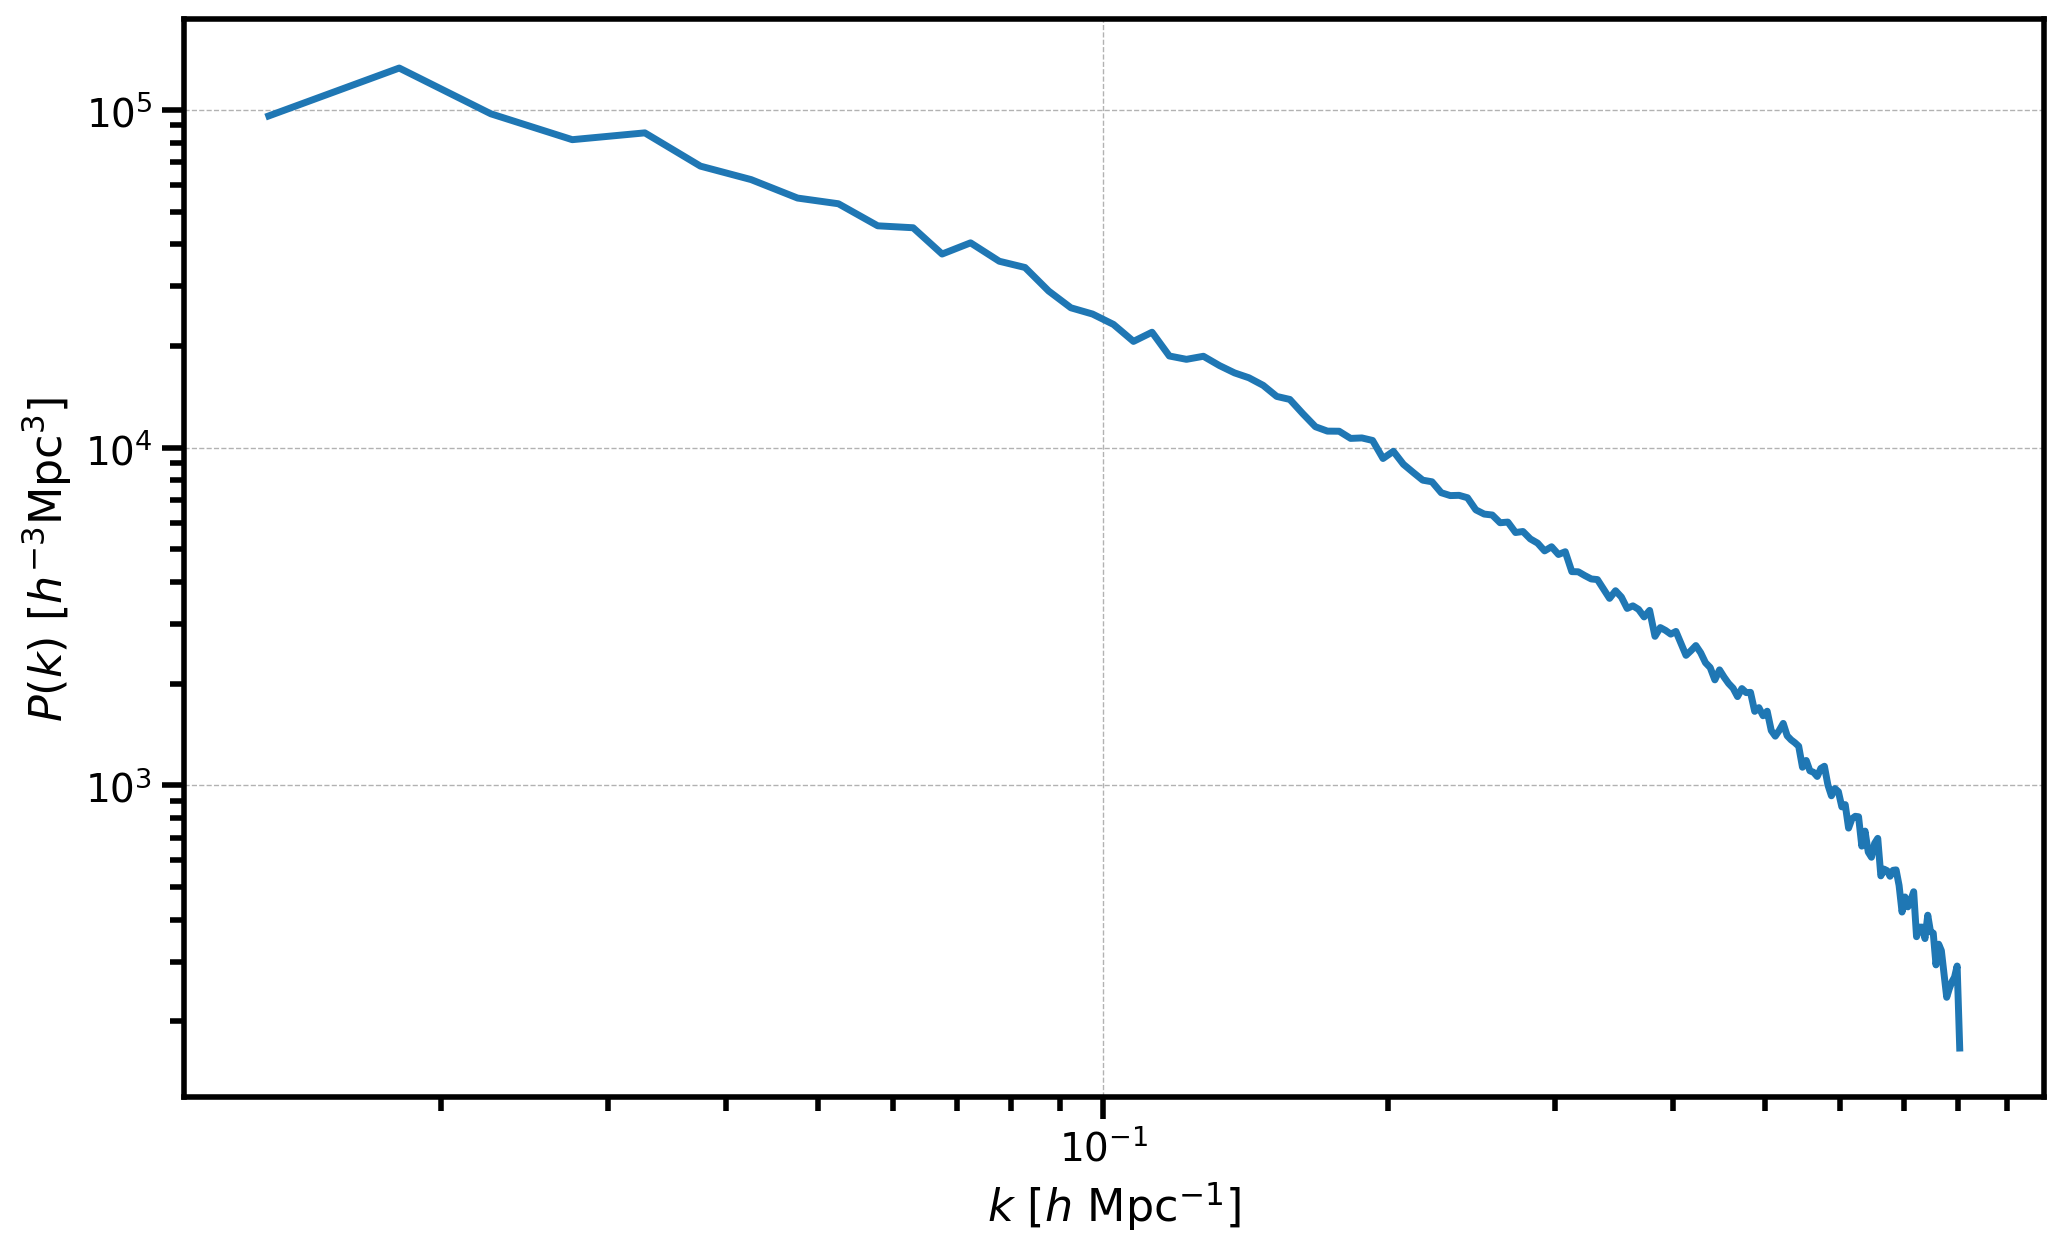

In [12]:
# print the shot noise subtracted P(k)
plt.loglog(Pk['k'], Pk['power'].real - Pk.attrs['shotnoise'])

# format the axes
plt.xlabel(r"$k$ [$h \ \mathrm{Mpc}^{-1}$]")
plt.ylabel(r"$P(k)$ [$h^{-3}\mathrm{Mpc}^3$]")
#plt.xlim(0.01, 0.6)

In [13]:
root = "/media/fuffolo97/HDD1/UNI/Tesi/halos/fiducial/"
in_realizations = os.listdir(root)

if os.path.exists('./Pk_nbk.pk'): os.remove('./Pk_nbk.pk')

for i in tqdm(range(len(in_realizations))):
    if i==0: continue

    snapdir =root + in_realizations[i]

    # reading datas
    datas = FoF_catalog(snapdir, snapnum, read_IDs=False)

    pos_h = (datas.GroupPos / 1e3).astype(np.float32)                     # positions in Mpc/h
    mass = (datas.GroupMass * 1e10).astype(np.float32)                  # masses in M_sun/
    vel = (datas.GroupVel * (1.0+redshift)).astype(np.float32)            # Halo peculiar velocities in km/s

    pos_rsd = []
    for i in range(len(vel)):
        pos_rsd.append(PacMan(pos_h[i] + (1+redshift) * np.array( ([0, 0, vel[i][2]/H_0]) ) ))
    pos_rsd = np.array(pos_rsd, dtype=np.float32)

    # create fale to store data
    if os.path.exists('./data_source_fiducial_1.dat'): os.remove('./data_source_fiducial_1.dat')

    with open('./data_source_fiducial_1.dat', "wb") as ff:
        pos_h.tofile(ff)
        pos_rsd.tofile(ff)
        vel.tofile(ff)
        mass.tofile(ff)
        ff.seek(0)

    # create nbodykit BinaryCatalog
    binCat = BinaryCatalog(ff.name, dtype_cust)

    # create mesh
    mesh = binCat.to_mesh(resampler='cic', Nmesh=256, compensated=True,
                      position='Position', weight="Mass",
                      BoxSize=BoxDim
                      )
    
    
    # evaluate FFTPower
    r_3d = FFTPower(mesh, mode='1d', dk=0.005, kmin=0.01)

    # get actual Power Spectrum datas
    Pk = r_3d.power

    # store Pk datas in a single file
    with open('./Pk_nbk.pk', 'ab') as file: pickle.dump(Pk, file)

  0%|          | 0/1000 [00:00<?, ?it/s]

[ 000018.34 ]   0: 09-27 16:05  CatalogSource   INFO     Extra arguments to FileType: ([('Position', (<class 'numpy.float32'>, 3)), ('RSDPosition', (<class 'numpy.float32'>, 3)), ('Velocity', (<class 'numpy.float32'>, 3)), ('Mass', <class 'numpy.float32'>)],) {}
[ 000018.37 ]   0: 09-27 16:05  CatalogMesh     INFO     Chunk 0 ~ 4194304 / 195784 
[ 000018.54 ]   0: 09-27 16:05  CatalogMesh     INFO     painted 195784 out of 195784 objects to mesh
[ 000018.54 ]   0: 09-27 16:05  CatalogMesh     INFO     painted 195784 out of 195784 objects to mesh
[ 000018.54 ]   0: 09-27 16:05  CatalogMesh     INFO     mean particles per cell is 3.54265e+11
[ 000018.54 ]   0: 09-27 16:05  CatalogMesh     INFO     sum is 5.94357e+18 
[ 000018.56 ]   0: 09-27 16:05  CatalogMesh     INFO     normalized the convention to 1 + delta
[ 000018.80 ]   0: 09-27 16:05  CatalogMesh     INFO     field: (BinaryCatalog(size=195784, FileStack(BinaryFile(path=/home/fuffolo97/TESI/data_source_fiducial_1.dat, dataset=*, n

In [18]:
every_pk = []
with open('./Pk_nbk.pk', 'rb') as file:
     while True:
                try:
                    a = pickle.load(file)
                    every_pk.append(a)
                except EOFError:
                    break


In [46]:
real_power = []

for i in range(len(every_pk)):
    real_power.append(every_pk[i]["power"].real  - every_pk[i].attrs['shotnoise'] )

real_power_mean = np.mean(real_power, axis=0)

(0.01, 0.6)

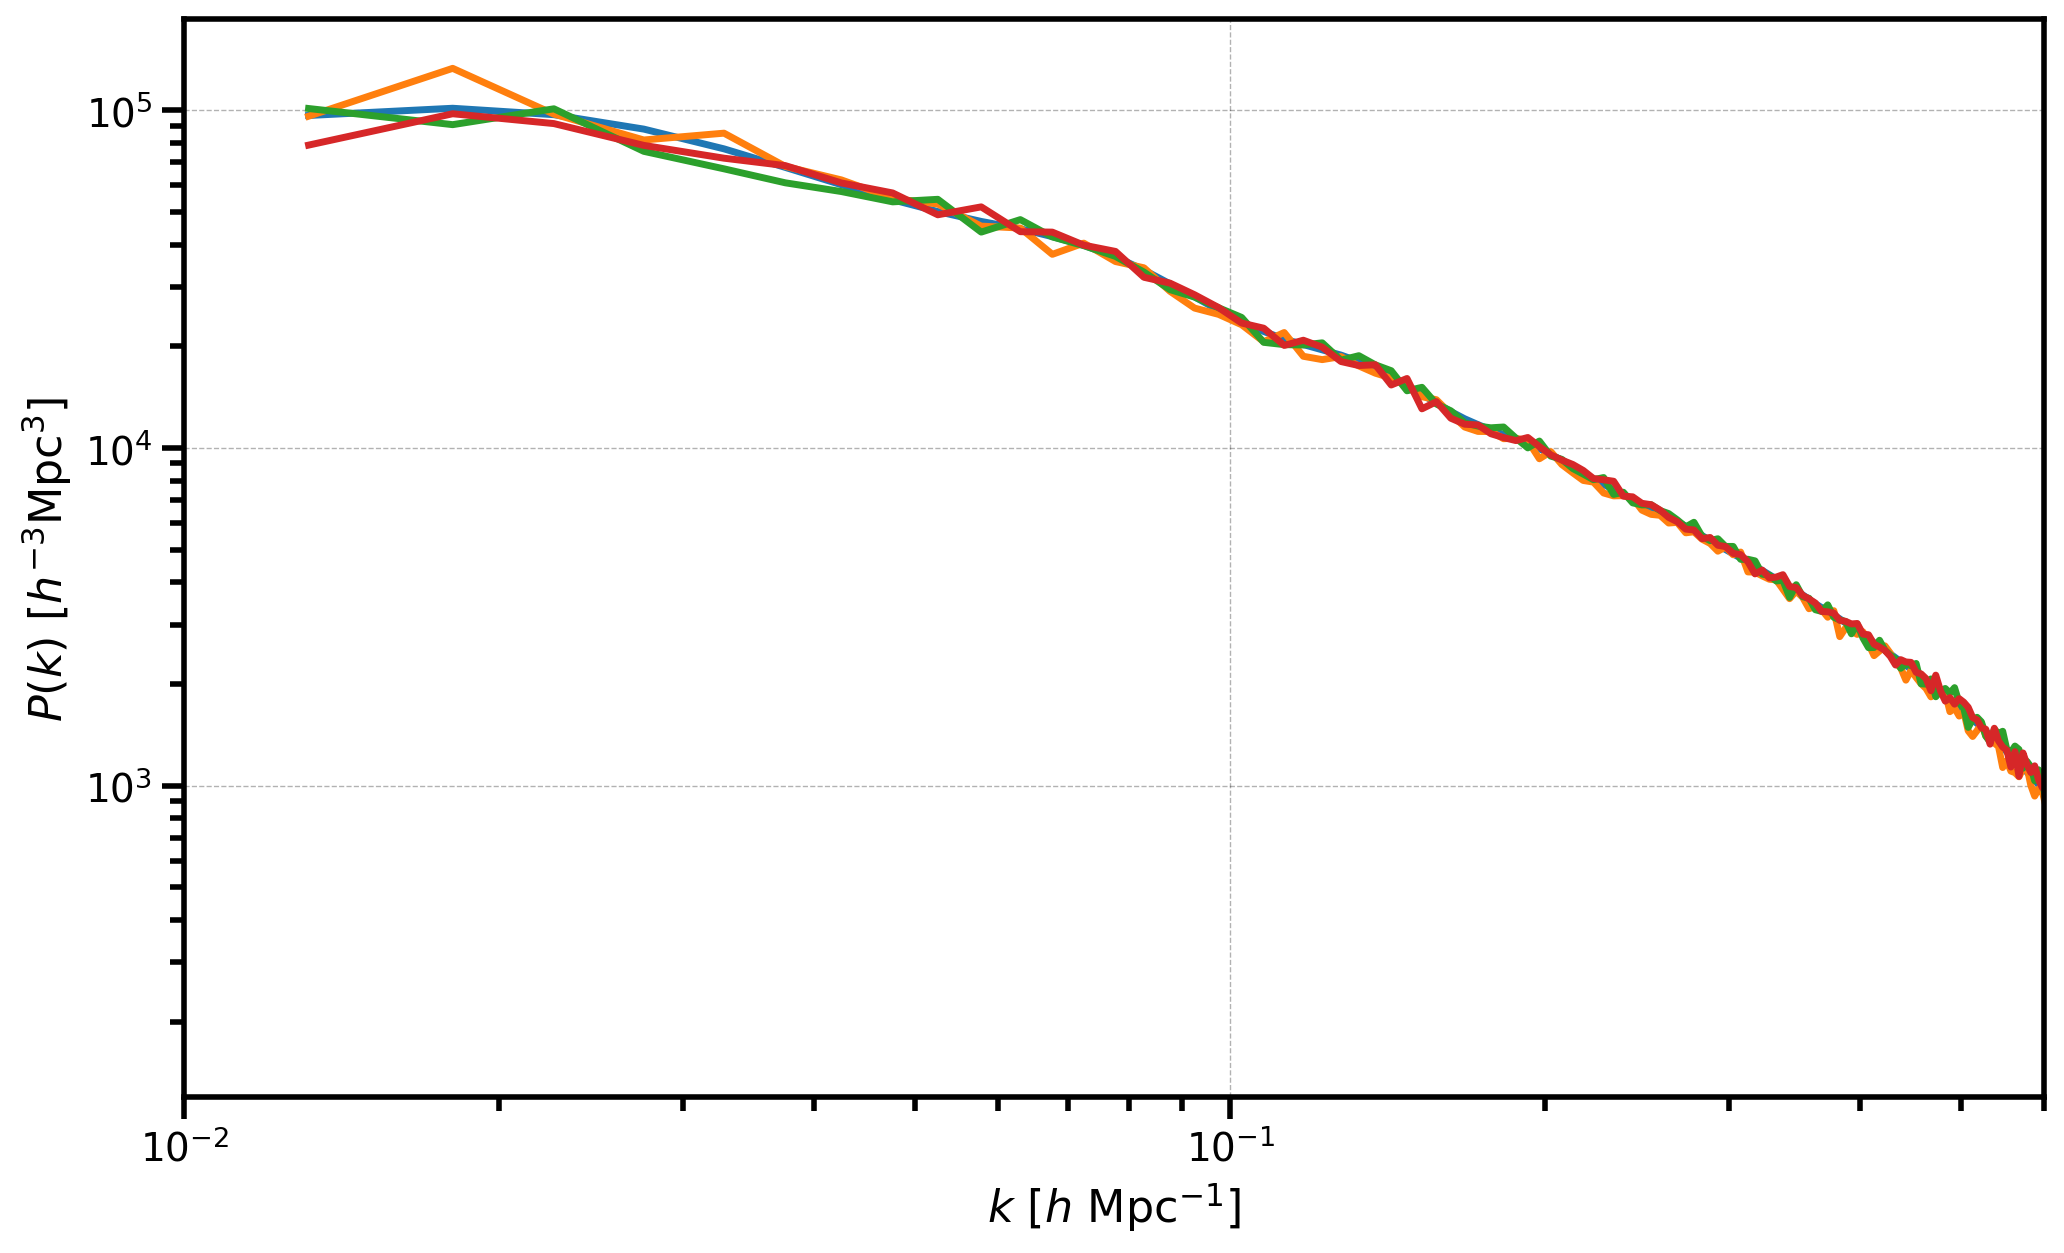

In [50]:
# print the shot noise subtracted P(k)
plt.loglog(every_pk[0]['k'], real_power_mean)
plt.loglog(every_pk[0]['k'], real_power[0])
plt.loglog(every_pk[0]['k'], real_power[10])
plt.loglog(every_pk[0]['k'], real_power[100])

# format the axes
plt.xlabel(r"$k$ [$h \ \mathrm{Mpc}^{-1}$]")
plt.ylabel(r"$P(k)$ [$h^{-3}\mathrm{Mpc}^3$]")
plt.xlim(0.01, 0.6)

# Derivates

## Read all files

In [51]:
root_pk = "/media/fuffolo97/HDD1/UNI/Tesi/Pk-files_08_08"
files_to_read_raw_pk = os.listdir(root_pk)

In [ ]:
files_to_read_N_pk = []
files_to_read_N_k_modes = []

monos_tot_N_pk = np.zeros((len(cosmologies), 221))
quads_tot_N_pk = np.zeros((len(cosmologies), 221))
multi_tot_N_pk = np.zeros((len(cosmologies), 221*2))
fiducial_mono_N_coeffs = []
fiducial_quad_N_coeffs = []
fiducial_multi_N = []
zeldovich_mono_N_coeffs = []
zeldovich_quad_N_coeffs = []
zeldovich_multi_N = []

fiducial_mono_0 = []
fiducial_quad_0 = []
fiducial_muti_0 = []


for i in range(len(files_to_read_raw_pk)):
    if "_Ns_" in files_to_read_raw_pk[i] and "400" not in  files_to_read_raw_pk[i] and "_Pk_M_" in files_to_read_raw_pk[i]: files_to_read_N_pk.append(files_to_read_raw_pk[i])

for i in range(len(files_to_read_raw_pk)):
    if "_Ns_" in files_to_read_raw_pk[i] and "400" not in  files_to_read_raw_pk[i] and "_k3D_M_" in files_to_read_raw_pk[i]: files_to_read_N_k_modes.append(files_to_read_raw_pk[i])


for i in range(len(files_to_read_N_pk)):
    coeffs_cosm_pk = []
    file_reading = files_to_read_N_pk[i]

    monopoles = []
    quadrupoles = []
    multipoles = []

    cosmo = cosmo_parser(file_reading)
    assert cosmo in file_reading
    # print("COSMO KEY: ", cosmo)
    index = order_folders[cosmo]

    assert (cosmo != "fiducial" and cosmo != "zeldovich") == (("fiducial" not in file_reading) and ("zeldovich" not in file_reading))
    
    if ("fiducial" not in file_reading) and ("zeldovich" not in file_reading):
        with open(root_pk + "/" + file_reading, 'rb') as Ff:
            while True:
                try:
                    a = pickle.load(Ff)
                    assert (221, 3) == np.shape(a), f"{cosmo}: {np.shape(a)}"
                    monopoles.append(a[:,0])
                    assert np.shape(a[:,0]) == (221,), f"it's {np.shape(a[:,0])}"
                    quadrupoles.append(a[:,1])
                    assert np.shape(a[:,1]) == (221,), f"it's {np.shape(a[:,1])}"

                    b1 = a[:,0].reshape(1, -1)
                    b2 = a[:,1].reshape(1, -1)
                    B = np.hstack([b1, b2]).ravel()
                    assert np.shape(B) == (442,), f"it's {np.shape(B)}"
                    multipoles.append(B)
                except EOFError:
                    break
                except RuntimeWarning:
                    print("problem here: ", file_reading)
        # print(np.shape(multipoles))
        assert np.shape(np.average(monopoles, axis=0)) == (221,)
        assert np.shape(np.average(quadrupoles, axis=0)) == (221,)
        assert np.shape(np.average(multipoles, axis=0)) == (442,)

    elif "fiducial" in file_reading:
        with open(root_pk + "/" + file_reading, 'rb') as Ff:
            while True:
                try:
                    a = pickle.load(Ff)
                    assert (221, 3) == np.shape(a), f"{cosmo}: {np.shape(a)}"
                    fiducial_mono_N_coeffs.append(a[:,0])
                    fiducial_quad_N_coeffs.append(a[:,1])

                    b1 = a[:,0].reshape(1, -1)
                    b2 = a[:,1].reshape(1, -1)
                    B = np.hstack([b1, b2]).ravel()
                    assert np.shape(B) == (442,), f"it's {np.shape(B)}"
                    fiducial_multi_N.append(B)
                except EOFError:
                    break
                except RuntimeWarning:
                    print("problem here: ", file_reading)
        fiducial_mono_0 = fiducial_mono_N_coeffs[0]
        fiducial_quad_0 = fiducial_quad_N_coeffs[0]
        fiducial_muti_0 = fiducial_multi_N[0]

        fiducial_mono_N_avg = np.average(fiducial_mono_N_coeffs, axis=0)
        fiducial_quad_N_avg = np.average(fiducial_quad_N_coeffs, axis=0)
        fiducial_multi_N_avg = np.average(fiducial_multi_N, axis=0)

    elif "zeldovich" in file_reading:
        # print("C, ", file_reading)
        with open(root_pk + "/" + file_reading, 'rb') as Ff:
            while True:
                try:
                    a = pickle.load(Ff)
                    assert (221, 3) == np.shape(a), f"{cosmo}: {np.shape(a)}"
                    zeldovich_mono_N_coeffs.append(a[:,0])
                    zeldovich_quad_N_coeffs.append(a[:,1])

                    b1 = a[:,0].reshape(1, -1)
                    b2 = a[:,1].reshape(1, -1)
                    B = np.hstack([b1, b2]).ravel()
                    assert np.shape(B) == (442,), f"it's {np.shape(B)}"
                    zeldovich_multi_N.append(B)
                except EOFError:
                    break
                except RuntimeWarning:
                    print("problem here: ", file_reading)
        zeldovich_mono_N_avg = np.average(zeldovich_mono_N_coeffs, axis=0)
        zeldovich_quad_N_avg = np.average(zeldovich_quad_N_coeffs, axis=0)
        zeldovich_multi_N_avg = np.average(zeldovich_multi_N, axis=0)
    else:
        assert False, "\n   ERROR in reading WST files, cosmology can't be propely interpreted.\n"

    # USING average  value per coefficient in cosmology
    if len(monopoles) == 0 and cosmo != "fiducial" and cosmo != "zeldovich":
        print(cosmo, " has problem!")
        print(cosmo, " : ", np.shape(monopoles))
    if cosmo != "fiducial" and cosmo != "zeldovich":
        #assert len(monopoles) == (221,), "wronng length for monopoles array"
        monos_tot_N_pk[index] = np.average(monopoles, axis=0)
        quads_tot_N_pk[index] = np.average(quadrupoles, axis=0)
        multi_tot_N_pk[index] = np.average(multipoles, axis=0)